# Hackathon

Импортируем модули

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import catboost as ctb
import tensorflow as tf

Читаем данные для трейна и сабмитта

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Ввиду не состыковки данных в описание и в датасете признака Fill Flag удалим его, да и вдобавок он просто описывает наличие данных, что для нас бесполезно.

In [3]:
df_train.drop('Fill Flag', axis=1, inplace=True)
df_test.drop('Fill Flag', axis=1, inplace=True)

Для начала разберемся с временем

In [4]:
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_train['Timestamp'])

<Axes: xlabel='Timestamp'>

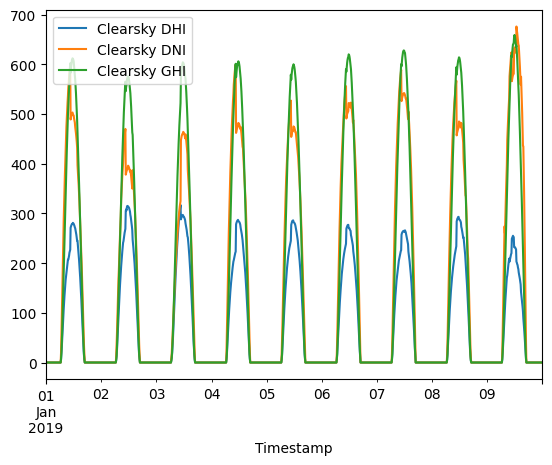

In [15]:
df_train[df_train['Timestamp'] < '2019-01-10'][['Timestamp', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']].plot(x='Timestamp')

На графике показано 10 первых дней из датасета, и можно увидеть явно выраженную зависимость от времени, а именно где-то в середине дня начинает увеличиваться, значит нам обязательно понадобится вытащить из Timestamp максимум данных

Время я буду извлекать двумя способами:
1. Просто извлечь числовые значения из Timestamp
2. Извлечь необходимые данные и преобразовать их в синус и косинус, таким образом модель будет понимать, что 23 час и 0 час это очень близкие значения

Почему не только второй способ(деревья лучше работают с первым способом)

In [5]:
# Первый способ
df_train['month']=df_train['Timestamp'].dt.month 
df_train['day']=df_train['Timestamp'].dt.day
df_train['dayofweek_num']=df_train['Timestamp'].dt.dayofweek
df_train['hours']=df_train['Timestamp'].dt.hour
df_train['minutes']=df_train['Timestamp'].dt.minute
# df_train['year']=df_train['Timestamp'].dt.year

df_test['month']=df_test['Timestamp'].dt.month 
df_test['day']=df_test['Timestamp'].dt.day
df_test['dayofweek_num']=df_test['Timestamp'].dt.dayofweek
df_test['hours']=df_test['Timestamp'].dt.hour
df_test['minutes']=df_test['Timestamp'].dt.minute
# df_test['year']=df_test['Timestamp'].dt.year

In [6]:
df_train.drop('Timestamp', axis=1, inplace=True)
df_test.drop('Timestamp', axis=1, inplace=True)

Впринципе данные готовы, но напоследок можно проверить наличие корреляции между признаками, для этого в начале стоит разбить данные на x и y, чтобы не выявить корреляции с целевой переменной

In [7]:
x_train = df_train.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)
y_train = df_train[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']]

In [8]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

Порог установим в 0.8, чтобы выявить признаки именно с сильной корреляцией

In [9]:
correlation(x_train, 0.8)

{'Precipitable Water'}

In [10]:
x_train.drop('Precipitable Water', axis=1, inplace=True)
df_test.drop('Precipitable Water', axis=1, inplace=True)

Теперь данные для обучения готовы(осталось только разбить их), начнем с RandomForest

In [11]:
def train_test_split1(x, test_frac=0.3):
    x_train = x[:round((1 - test_frac) * len(x))]
    x_test = x[round((1 - test_frac) * len(x)):]
    return x_train, x_test

x_train, x_test = train_test_split1(x_train)
y_train, y_test = train_test_split1(y_train)

In [12]:
model = RandomForestRegressor(n_jobs=-1, random_state=27)

model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=27)

In [13]:
pred = model.predict(x_test)
mean_squared_error(y_test, pred)

2224.6258979388626

In [14]:
x_sub = df_test.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)

df_sub = pd.read_csv('submission.csv')

y_sub = model.predict(x_sub)


df_sub.loc[:, :] = y_sub

df_sub.to_csv('my_submission_file.csv', index=False)

MSE на сабмите получилось 2825, попробуем настроить гиперпараметры, так как MSE на трейне в 5 раз лучше чем на валидационной - переобучение

In [ ]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=27)

param_grid = {
    'max_depth': [5, 10, 15, 20, None]
}

cv = 5

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search.fit(x_train, y_train)

print(f"Лучшее значение max_depth: {grid_search.best_params_['max_depth']}")

Лучшее значение для глубины это None, посмотрим есть ли смысл min_sample_leaf

In [ ]:
tree = RandomForestRegressor(n_jobs=-1, random_state=27)

param_grid = {'min_samples_leaf': [1, 5, 10, 15, 20]}
cv = 5

grid_search = GridSearchCV(tree, param_grid=param_grid, cv=cv)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

Этот параметр тоже бесполезно настраивать

Разберемся получше в целевых переменных, они у нас зависят друг от друга(прочитал в статье) 
<img src=https://www.researchgate.net/publication/362326479/figure/fig1/AS:1183120170721294@1659089238616/Equation-of-calculating-GHI-using-DNI-and-DHI.ppm>

Создадим 3 модели, которые поэтапно предсказывают данные, а затем использует эти данные для дальнейшего предсказания

In [11]:
x_train1 = df_train.drop(['Clearsky DHI', 'Clearsky GHI', 'Clearsky DNI', 'Precipitable Water'], axis=1)
x_train2 = df_train.drop(['Clearsky DNI', 'Clearsky GHI', 'Precipitable Water'], axis=1)
x_train3 = df_train.drop(['Clearsky GHI', 'Precipitable Water'], axis=1)

In [12]:
x_strain1, x_stest1 = train_test_split(x_train1, train_size=0.7, random_state=27)  
x_strain2, x_stest2 = train_test_split(x_train2, train_size=0.7, random_state=27)
x_strain3, x_stest3 = train_test_split(x_train3, train_size=0.7, random_state=27)

In [13]:
y_train = df_train[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']]
y_train, y_test = train_test_split(y_train, train_size=0.7, random_state=27)

In [ ]:
x_strain1, x_stest1 = train_test_split1(x_train1)  
x_strain2, x_stest2 = train_test_split1(x_train2)
x_strain3, x_stest3 = train_test_split1(x_train3)

In [15]:
y_train1 = y_train['Clearsky DHI']
y_train2 = y_train['Clearsky DNI']
y_train3 = y_train['Clearsky GHI']

In [16]:
model1 = RandomForestRegressor(n_estimators=200,  n_jobs=-1, random_state=27)

model1.fit(x_strain1, y_train1)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=27)

In [17]:
pred = model1.predict(x_stest1)
mean_squared_error(y_test['Clearsky DHI'], pred)

103.85428557085552

In [18]:
model2 = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=27)

model2.fit(x_strain2, y_train2)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=27)

In [19]:
pred = model2.predict(x_stest2)
mean_squared_error(y_test['Clearsky DNI'], pred)

266.7313242044806

In [20]:
model3 = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=27)

model3.fit(x_strain3, y_train3)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=27)

In [21]:
pred = model3.predict(x_stest3)
mean_squared_error(y_test['Clearsky GHI'], pred)

6.97158713652651

Показатели на валидации значительно улучшилось, посмотрим что с тестовой частью

In [22]:
x_sub = df_test.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)

df_sub = pd.read_csv('submission.csv')

y_sub1 = model1.predict(x_sub)

In [23]:
x_sub1 = df_test.drop(['Clearsky DNI', 'Clearsky GHI'], axis=1)
x_sub2 = df_test.drop(['Clearsky GHI'], axis=1)

In [24]:
x_sub1['Clearsky DHI'] = y_sub1

In [25]:
y_sub2 = model2.predict(x_sub1)

In [26]:
x_sub2['Clearsky DHI'] = y_sub1
x_sub2['Clearsky DNI'] = y_sub2

In [27]:
y_sub3 = model3.predict(x_sub2)

In [28]:
df_sub.iloc[:, 0] = y_sub1
df_sub.iloc[:, 1] = y_sub2
df_sub.iloc[:, 2] = y_sub3

In [29]:
df_sub.to_csv('my_submission_file.csv', index=False)

Результат MSE = 2613, результаты улучшились на 100 единиц

Это лучший результат, который у меня получился, я помимо деревьев перепробовал множество других моделей, но эта модель показала себя лучше всех. Ниже представлены некоторые из этих моделей и таблица с результатами этих моделей на тесте

Для catboost изменим разбиение данных на train val test, так как у нас данные перемешались, и моделью может быть не замечена закономерность от времени

In [3]:
pd.DataFrame([['>5000'], ['3000-4000'], ['2900-3000'], ['2800-3000'], ['2613']], columns=['MSE'], index=['Linear', 'DeepLearn', 'CatBoost', 'Prophet', 'RandomForest'])

,MSE
Linear,>5000
DeepLearn,3000-4000
CatBoost,2900-3000
Prophet,2800-3000
RandomForest,2613


Ниже представлены некоторые из этих моделей

## CatBoost

In [5]:
# Второй способ
timestamp_s = df_test.pop('Timestamp').map(pd.Timestamp.timestamp)
hour = 60*60
day = 24*hour
minut = 60
# year = (365.2425)*day
df_test['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df_test['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df_test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_test['Min sin'] = np.sin(timestamp_s * (2 * np.pi / minut))
df_test['Min cos'] = np.cos(timestamp_s * (2 * np.pi / minut))
# df_test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df_test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

timestamp_s = df_train.pop('Timestamp').map(pd.Timestamp.timestamp)
df_train['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df_train['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df_train['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_train['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_train['Min sin'] = np.sin(timestamp_s * (2 * np.pi / minut))
df_train['Min cos'] = np.cos(timestamp_s * (2 * np.pi / minut))

In [6]:
def train_val_test_split(x, val_frac=0.15, test_frac=0.15):
    x_train = x[:round((1 - val_frac - test_frac) * len(x))]
    x_val = x[round((1 - val_frac - test_frac) * len(x)):round((1 - test_frac) * len(x))]
    x_test = x[round((1 - test_frac) * len(x)):]
    return x_train, x_val, x_test


x_train, x_val, x_test = train_val_test_split(df_train.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Precipitable Water'], axis=1))
y_train, y_val, y_test = train_val_test_split(df_train[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']])

In [9]:
model = ctb.CatBoostRegressor(iterations=500, loss_function='MultiRMSE', eval_metric='MultiRMSE', random_state=27, verbose=0)

model.fit(x_train, y_train, eval_set=(x_val, y_val))

In [10]:
pred1 = model.predict(x_test)
pred = model.predict(x_train)

In [11]:
mean_squared_error(y_train, pred), mean_squared_error(y_test, pred1)

(1383.8078294206287, 2584.571355554805)

In [16]:
x_sub = df_test.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)

df_sub = pd.read_csv('submission.csv')

y_sub = model.predict(x_sub)

df_sub.loc[:, :] = np.around(y_sub, 2)

In [17]:
df_sub['Clearsky DHI'] = df_sub['Clearsky DHI'].apply(lambda x: 0 if x<1 else round(x,2))
df_sub['Clearsky DNI'] = df_sub['Clearsky DNI'].apply(lambda x: 0 if x<1 else round(x,2))
df_sub['Clearsky GHI'] = df_sub['Clearsky GHI'].apply(lambda x: 0 if x<1 else round(x,2))

In [18]:
df_sub.to_csv('my_submission_file.csv', index=False)

## Deep Learning

In [91]:
input1 = tf.keras.layers.Input(shape=x_train.iloc[0].shape)
x = tf.keras.layers.Dense(20, activation='relu')(input1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.01)(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.01)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
dhi = tf.keras.layers.Dense(100, activation='relu')(x)
ghi = tf.keras.layers.Dense(100, activation='relu')(x)
dni = tf.keras.layers.Dense(100, activation='relu')(x)
dhi = tf.keras.layers.BatchNormalization()(dhi)
ghi = tf.keras.layers.BatchNormalization()(ghi)
dni = tf.keras.layers.BatchNormalization()(dni)
dhi = tf.keras.layers.Dropout(rate=0.01)(dhi)
ghi = tf.keras.layers.Dropout(rate=0.01)(ghi)
dni = tf.keras.layers.Dropout(rate=0.01)(dni)
dhi = tf.keras.layers.Dense(50, activation='relu')(dhi)
ghi = tf.keras.layers.Dense(50, activation='relu')(ghi)
dni = tf.keras.layers.Dense(50, activation='relu')(dni)
dhi = tf.keras.layers.BatchNormalization()(dhi)
ghi = tf.keras.layers.BatchNormalization()(ghi)
dni = tf.keras.layers.BatchNormalization()(dni)
dhi = tf.keras.layers.Dropout(rate=0.01)(dhi)
ghi = tf.keras.layers.Dropout(rate=0.01)(ghi)
dni = tf.keras.layers.Dropout(rate=0.01)(dni)
output1 = tf.keras.layers.Dense(1, activation='relu', name='dhi')(dhi)
output2 = tf.keras.layers.Dense(1, activation='relu', name='ghi')(ghi)
output3 = tf.keras.layers.Dense(1, activation='relu', name='dni')(dni)

model = tf.keras.Model(inputs=input1, outputs=[output1, output2, output3])

In [92]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_37 (Dense)               (None, 20)           340         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 20)          80          ['dense_37[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_38 (Dense)               (None, 100)          2100        ['batch_normalization_15[0]

In [93]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mean_squared_error)

In [94]:
annealing = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1,
                                                 patience=5,
                                                 verbose=1,
                                                 min_delta=0.001)

In [95]:
model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          batch_size = 1000,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=15), annealing],
          epochs=100)

Epoch 1/100
148/148 [==============================] - 7s 20ms/step - loss: 308623.5000 - dhi_loss: 103373.4453 - ghi_loss: 103006.6328 - dni_loss: 102243.3984 - val_loss: 259571.8281 - val_dhi_loss: 86991.8750 - val_ghi_loss: 86635.2734 - val_dni_loss: 85944.6484 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 2s 16ms/step - loss: 282959.1875 - dhi_loss: 94844.4141 - ghi_loss: 94568.6562 - dni_loss: 93546.0625 - val_loss: 253359.2969 - val_dhi_loss: 84681.3984 - val_ghi_loss: 84735.0859 - val_dni_loss: 83942.8047 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 2s 16ms/step - loss: 251759.3281 - dhi_loss: 84408.5156 - ghi_loss: 84220.2812 - dni_loss: 83130.5156 - val_loss: 260654.5312 - val_dhi_loss: 86400.6875 - val_ghi_loss: 86539.0000 - val_dni_loss: 87714.8281 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 2s 16ms/step - loss: 215724.0938 - dhi_loss: 72324.2344 - ghi_loss: 72217.7344 - dni_loss: 71182.1719 - val_loss: 274

In [99]:
pred = model.predict(x_test)

986/986 [==============================] - 2s 2ms/step


In [100]:
predi = pd.DataFrame(np.concatenate((pred[0], pred[1], pred[2]), axis=1))

In [101]:
mean_squared_error(y_test, predi)

15859.869737317014

Не получилось, попробуем поработать с временным рядом

In [102]:
df_train_time = pd.read_csv('train.csv', index_col=['Timestamp'], parse_dates=['Timestamp'], dayfirst=True)

<Axes: xlabel='Timestamp'>

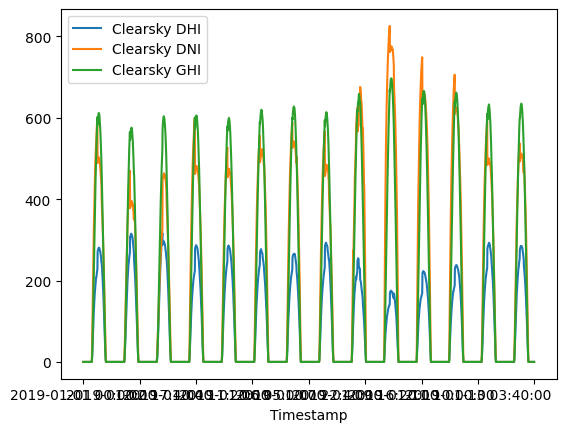

In [117]:
df_train_time.iloc[:2000][['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']].plot()

## Prophet

Можно заметить переодичность значений в целевых переменных, следовательно можно анализировать эту задачу как временной ряд, в качестве модели буду использовать prophet от Facebook

In [121]:
from prophet import Prophet

In [30]:
df_train_time = pd.read_csv('train.csv')

df_train_time['Timestamp'] = pd.to_datetime(df_train_time['Timestamp'])

df_train_time_1 = df_train_time[['Timestamp', 'Clearsky DHI']].rename(columns={'Clearsky DHI': 'y', 'Timestamp': 'ds'})
df_train_time_2 = df_train_time[['Timestamp', 'Clearsky DNI']].rename(columns={'Clearsky DNI': 'y', 'Timestamp': 'ds'})
df_train_time_3 = df_train_time[['Timestamp', 'Clearsky GHI']].rename(columns={'Clearsky GHI': 'y', 'Timestamp': 'ds'})
df_train_time = df_train_time.rename(columns={'Timestamp': 'ds'})

df_train_time_1 = pd.merge(df_train_time_1, df_train_time.drop(['Fill Flag','Precipitable Water', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1),
                                                               on='ds', how='left')

df_train_time_2 = pd.merge(df_train_time_2, df_train_time.drop(['Fill Flag','Precipitable Water', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1),
                                                               on='ds', how='left')
df_train_time_3 = pd.merge(df_train_time_3, df_train_time.drop(['Fill Flag','Precipitable Water', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1),
                                                               on='ds', how='left')

In [31]:
def train_test_split1(x, test_frac=0.15):
    x_train = x[:round((1 - test_frac) * len(x))]
    x_test = x[round((1 - test_frac) * len(x)):]
    return x_train, x_test

x_train1, x_test1 = train_test_split1(df_train_time_1)
x_train2, x_test2 = train_test_split1(df_train_time_2)
x_train3, x_test3 = train_test_split1(df_train_time_3)

In [190]:
model1 = Prophet()
for i in df_train_time_1.columns[2:]:
    model1.add_regressor(f'{i}')

model1.fit(df_train_time_1)

21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing


In [191]:
model2 = Prophet()
for i in df_train_time_2.columns[2:]:
    model2.add_regressor(f'{i}')

model2.fit(df_train_time_2)

21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:43 - cmdstanpy - INFO - Chain [1] done processing


In [192]:
model3 = Prophet()
for i in df_train_time_3.columns[2:]:
    model3.add_regressor(f'{i}')

model3.fit(df_train_time_3)

21:31:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing


In [219]:
df_sub = pd.read_csv('submission.csv')

forecast1 = model1.predict(df_test_time_1)
forecast2 = model2.predict(df_test_time_2)
forecast3 = model3.predict(df_test_time_3)

df_sub['Clearsky DHI'] = forecast1['yhat']
df_sub['Clearsky DNI'] = forecast2['yhat']
df_sub['Clearsky GHI'] = forecast3['yhat']

df_sub['Clearsky DHI'] = df_sub['Clearsky DHI'].apply(lambda x: 0 if x<1 else round(x,2))
df_sub['Clearsky DNI'] = df_sub['Clearsky DNI'].apply(lambda x: 0 if x<1 else round(x,2))
df_sub['Clearsky GHI'] = df_sub['Clearsky GHI'].apply(lambda x: 0 if x<1 else round(x,2))

In [ ]:
df_sub.to_csv('my_submission_file.csv', index=False)